Import all necessary packages

In [9]:
import cvxpy as cp
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Read in travel times matrix from google maps API output

In [13]:
travel_times_df = pd.read_csv('/Users/gulizerdem/Desktop/OSU AU23/cabs_matrix_seconds.csv')
travel_times_df.rename(columns = {"Unnamed: 0": "from_stop"}, inplace = True)

Set up 20 stop problem with CVXPY

In [14]:
## Potential stops refer to all 25 locations where one of the 20 final stops MAY be placed
potential_stops = travel_times_df['from_stop'].tolist()
num_potential_stops = len(potential_stops)

## Set the number of stops​ you want here
## We are using 20 to lower travel times but still avoid drastically chaging the prevalence of bus stops on campus
num_stops = 20

## Declare decision variables​

## Binary variable matrix describing whether a connection between any two potential stops is present
x = cp.Variable((num_potential_stops, num_potential_stops), boolean=True)
## Binary variable vector describing whether each potential stop is present in the final solution
y = cp.Variable(num_potential_stops, boolean=True)

## Objective function​
## We want to minimize the total time that the campus connect loop takes (to allow buses to visit each stop more frequently)
## We use travel times from google maps API to do so
obj_func = cp.sum(cp.sum([x[:, j] @ travel_times_df[potential_stops[j]] for j in range(num_potential_stops)]))

# Set up constraints​
constraints = []

## Every stop is visited at most once
constraints.append(cp.sum(x, axis=0) <= 1)
constraints.append(cp.sum(x, axis=1) <= 1)

## Stop inclusion constraints
for j in range(num_potential_stops):
    constraints.append(cp.sum(x[:, j]) == y[j])
    for i in range(num_potential_stops):
        constraints.append(y[j] >= x[i,j])
        if (i == j):
            ## Constraint preventing connection between the same stop
            constraints.append(x[i,j] == 0)

## Number of stops constraint​
constraints.append(cp.sum(y) == num_stops)

## Cycle completion constraint​ (only one edge goes into each node and only one comes out)
constraints.append(cp.sum(x, axis=1) == cp.sum(x, axis=0))

## Avoiding subtours constraints
t = cp.Variable(num_potential_stops, nonneg=True) ## Auxilary variables (for each potential stop)

for i in range(1,num_potential_stops):
    for j in range(1,num_potential_stops):
        if i != j:
            constraints.append(t[i] - t[j] + num_stops*x[i,j] <= (num_stops - 1))

## University budget constraint
## The university's budget is $20,000 and each new bus shelter costs $10,000
## Indices of the potential new stops in y are: 22 (Stadium and RPAC), 23 (Campbell Hall), and 24 (Bricker Hall)
constraints.append(10000*y[22] + 10000*y[23] + 10000*y[24] <= 20000)

## Edges (stop connections) to avoid constraints
## (These were determined manually by taking into account directions of traffic and road rules on campus)
edges_to_avoid = [[1, 0], [2, 1], [2, 15], [15, 2], [3, 2], [3, 14], [14, 3], [4, 3], [4, 13], [13, 4],
                    [5, 4], [5, 12], [12, 5], [9, 7], [9, 8], [12, 11], [18, 21], [21, 18], [19, 18],
                    [2, 16], [15, 1], [1, 15], [3, 15], [15, 3], [22, 14], [4, 22], [0, 24], [0, 22],
                    [15, 13], [15, 14], [15, 22], [22, 15], [14, 22], [14, 13], [1, 24], [2, 24]]

for indices in edges_to_avoid:
    constraints.append(x[indices[0], indices[1]] == 0)

## Create the minimization problem
problem = cp.Problem(cp.Minimize(obj_func), constraints)

## Use GUROBI to solve
problem.solve(solver=cp.GUROBI,verbose = False)

## Print solution
print("obj_func =")
print(obj_func.value)
print("x =")
print(x.value)
print("y =")
print(y.value)

obj_func =
1760.0
x =
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0

Quickly visualize the resulting route by creating a graph from the solution

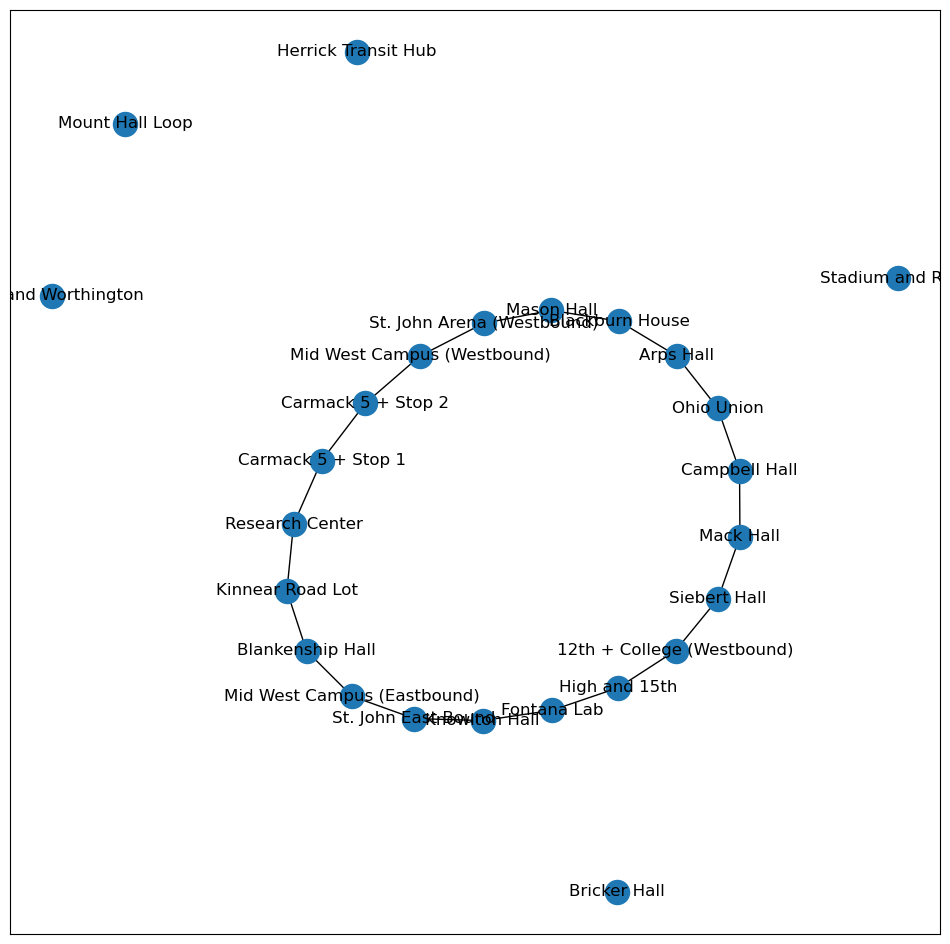

In [17]:
## Create an adjacency matrix of connected stops from x
x_array = np.array(x.value)
adj_mtrx = np.where(x_array==1)

adj_mtrx = [adj_mtrx[0].tolist(), adj_mtrx[1].tolist()]
adj_mtrx = np.transpose(adj_mtrx).tolist()

## Make graph figure
G = nx.Graph()
for n in range(25):
    G.add_node(n)
for i in range(len(adj_mtrx)):
    G.add_edge(*adj_mtrx[i])

## Rename the nodes with the actual corresponding stop names
mapping = {0:'Ohio Union',
    1:'Arps Hall',
    2:'Blackburn House',
    3:'Mason Hall',
    4:'St. John Arena (Westbound)',
    5:'Mid West Campus (Westbound)',
    6:'Mount Hall Loop',
    7:'Carmack 5 + Stop 1',
    8:'Carmack 5 + Stop 2',
    9:'Research Center',
    10:'Kinnear Road Lot',
    11:'Blankenship Hall',
    12:'Mid West Campus (Eastbound)',
    13:'St. John East Bound',
    14:'Knowlton Hall',
    15:'Fontana Lab',
    16:'High and 15th',
    17:'12th + College (Westbound)',
    18:'Siebert Hall',
    19:'Mack Hall',
    20:'Herrick Transit Hub',
    21:'11th and Worthington',
    22:'Stadium and RPAC',
    23:'Campbell Hall',
    24:'Bricker Hall'}

G = nx.relabel_nodes(G, mapping)

plt.figure(2,figsize=(12,12)) 
nx.draw_networkx(G)
plt.show()